In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

In [2]:
from unagi import hsc
from unagi import mask
from unagi.task import hsc_cutout, hsc_tricolor, hsc_psf, hsc_check_coverage
from unagi.sky import SkyObjs, AperPhot, S18A_APER, S18A_APER_ID

# Setup HSC server
s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide', verbose=False)

# Initialize skyobj catalog
sky_cat_use = Table.read('./Catalog/s18a_wide_fdfc_skyobject_flux.fits', format='fits')
sky_test = SkyObjs(sky_cat_use)

In [3]:
from lvhuo.stack import Stack, StackSky
from lvhuo.display import (display_single, display_multiple, \
                           draw_circles, draw_rectangles, SEG_CMAP)
from lvhuo.image import query_star, extract_obj

In [5]:
obj_coor = SkyCoord(29.41898541, -4.70075704, unit='deg') # object coordinate
# Download image
hdu = hsc_cutout(obj_coor, cutout_size=4 * u.arcmin, archive=s18a, 
                 filters='r', mask=True)
simg = Stack(hdu[1].data, header=hdu[1].header)
simg.hscmask = hdu[2].data
simg.mask = mask.Mask(simg.hscmask, data_release='s18a').extract('DETECTED').astype(float)
hdu.close()

# Retrieving cutout image in filter: r


In [6]:
# Select `skyobj` within the bound of image
skyobjs = Table(sky_test.select_box(*tuple(simg.sky_bounds)).skyobjs)

In [43]:
# Construct and stack `skyobjs`.
size = int(S18A_APER['aper118'].r_pix * 2)
stack_set = np.zeros((len(skyobjs), size, size))
bad_indices = []
for i, obj in enumerate(skyobjs):
    try:
        ssky = StackSky(simg.image, simg.header, obj, mask=simg.mask, aper_name='aper118')
        ssky.centralize(order=5)
        stack_set[i, :, :] = ssky.get_masked_image(cval=np.nan)
    except:
        stack_set[i, :, :] = np.ones((size, size)) * 1e9
        bad_indices.append(i)
stack_set = np.delete(stack_set, bad_indices, axis=0)
median_psf = np.nanmedian(stack_set, axis=0)

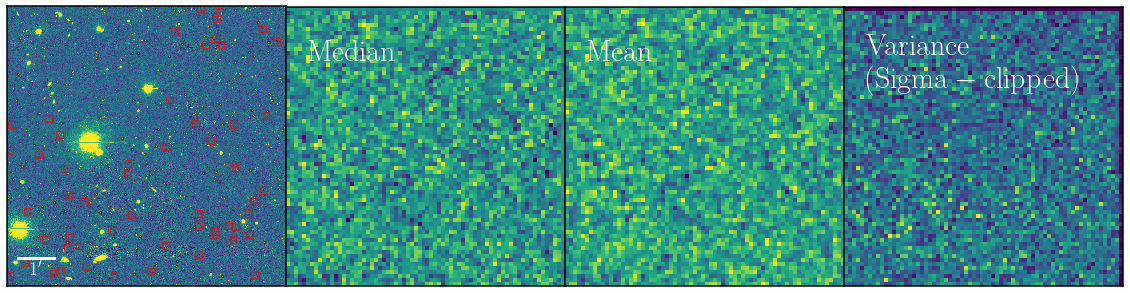

In [45]:
# Plot results
fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize=(20, 8))
draw_rectangles(simg.image, skyobjs, ax=ax1, colnames=['ra', 'dec'],
                header=simg.header, rectangle_size=[size, size], 
                scale_bar_length=61, scale_bar_y_offset=0.4)

display_single(np.nanmedian(stack_set, axis=0), ax=ax2, 
               scale_bar=False, add_text='Median')

display_single(np.nanmean(stack_set, axis=0), ax=ax3, 
               scale_bar=False, add_text='Mean')

display_single(np.var(sigma_clip(stack_set, axis=0), axis=0), ax=ax4, 
               scale_bar=False, 
               add_text='Variance}$\n $\mathrm{(Sigma-clipped)', text_y_offset=0.7)

plt.subplots_adjust(wspace=0.0)
#plt.savefig('./stack_sky.png', dpi=100, bbox_inches='tight')